In [1]:
# !pip install umap-learn
# !pip install imblearn
# !pip install xgboost
# !pip install keras
# !pip install tensorflow

In [1]:
# Libraries
import pickle
import zipfile

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
#import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import umap.umap_ as umap
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from keras.layers import Dense, Input
from keras.models import Model
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import (average_precision_score, confusion_matrix,
                             f1_score, log_loss, mean_squared_error,
                             precision_score, recall_score, roc_auc_score)
#import sklearn as sklearn
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import minmax_scale

2023-03-09 04:15:22.123932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 04:15:22.270564: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-09 04:15:22.270596: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 04:15:23.327161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
df = pd.read_parquet('df_full_new.parquet', engine='pyarrow')
df.head()

,TransactionID,TransactionDT,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_36_unknown,id_37_F,id_37_T,id_37_unknown,id_38_F,id_38_T,id_38_unknown,DeviceType_desktop,DeviceType_mobile,DeviceType_unknown
0,2987000,86400,0,68.5,13926.0,0.0,150.0,142.0,315.0,87.0,...,1,0,0,1,0,0,1,0,0,1
1,2987001,86401,0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,...,1,0,0,1,0,0,1,0,0,1
2,2987004,86506,0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,...,0,0,1,0,0,1,0,0,1,0
3,2987006,86522,0,159.0,12308.0,360.0,150.0,166.0,126.0,87.0,...,1,0,0,1,0,0,1,0,0,1
4,2987007,86529,0,422.5,12695.0,490.0,150.0,226.0,325.0,87.0,...,1,0,0,1,0,0,1,0,0,1


In [3]:
# drop TransactionDT
df.drop('TransactionDT', axis=1, inplace=True)
df.shape[1]


524

## Train vs Test Splitting

In [4]:
# define the feature and target variables
X = df.drop('isFraud', axis=1)
Y = df.isFraud  

# split the data into training and testing sets, stratifying on the target variable
X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.2, stratify=Y, random_state=42)

In [5]:
y_train.value_counts()

0    398448
1     15529
Name: isFraud, dtype: int64

## SMOTE

In [6]:
# create the SMOTE object
smote = SMOTE(sampling_strategy='auto')

In [7]:
# resample the data using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## PCA 

In [17]:
# std
X_train_resampled_std = (X_train_resampled - X_train_resampled.mean())/(X_train_resampled.std())

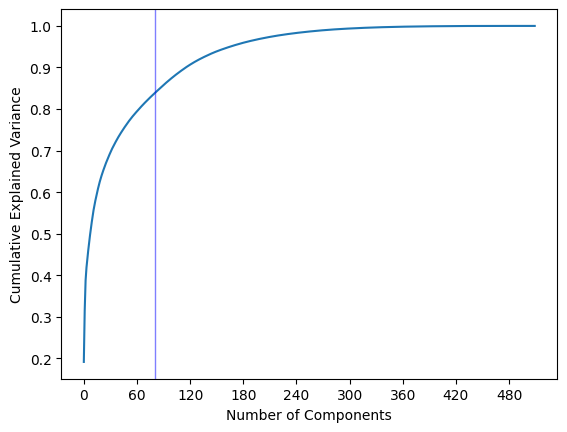

In [18]:
# PCA -- plot -> find # of components
ax = plt.figure().gca()
pca = PCA().fit(X_train_resampled_std)
# graph -> Number of Components vs Cumulative Explained Variance
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.axvline(x=80, linewidth=1, color='b', alpha=0.5)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [19]:
# explained variance by number of components
pca = PCA(n_components=80)
pca.fit(X_train_resampled_std)
pca.explained_variance_ratio_.sum()

0.8344339361863303

In [20]:
# built PCA with the around 85% CEV
df_pca_use_later= PCA(n_components=80)
df_pca= df_pca_use_later.fit_transform(X_train_resampled_std)
df_pca = pd.DataFrame(data = df_pca)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-9.524377,1.012822,-0.765243,1.090000,-3.288317,-1.185372,2.934064,2.876493,-0.663098,0.572543,...,-0.624967,-0.031104,1.351396,-0.037882,-0.063125,-0.179811,0.166932,0.421812,-0.444264,0.150143
1,-9.392617,0.778340,-0.673866,1.165278,-3.092596,-1.306844,2.358135,2.618431,-0.510287,0.542278,...,0.644702,0.098182,-0.238091,-0.312239,-0.224692,-0.010262,0.161297,0.459679,0.325148,-0.253840
2,-7.699234,0.955505,1.819554,-0.691221,-3.154929,-0.445490,3.475565,2.757652,-0.725291,-0.035429,...,-0.254616,-0.317104,0.190653,-0.065348,0.170685,0.222608,-0.701206,-0.191510,-0.218392,-0.076226
3,-4.572561,0.068618,2.212856,-2.543646,-2.473335,-0.342906,2.559165,2.104671,-0.215644,-0.437577,...,2.415470,0.474685,-3.996918,1.956228,-0.611031,1.919386,0.675616,0.895796,0.551755,0.678399
4,-9.433965,1.209940,-0.953494,1.611574,-1.787237,-1.202345,1.562597,2.394861,-0.238890,0.716814,...,-0.010926,-0.031287,-1.048192,-1.575709,0.090523,-0.091034,-0.927510,-0.063700,-0.390236,-0.021420


In [14]:
# reconstruction error
# Reconstruct data from the reduced representation
X_reconstructed = pca.inverse_transform(pca.transform(X_train_resampled_std))
# Calculate reconstruction error
reconstruction_error = mean_squared_error(X_train_resampled_std, X_reconstructed)
print(f"Reconstruction error: {reconstruction_error}")

Reconstruction error: 2.8694792584406262e-30


transform X_test as well


In [23]:
X_test_pca = df_pca_use_later.transform(X_test)
X_test_pca = pd.DataFrame(data = X_test_pca)

save it

In [24]:
# Checkpoint - output to pickle
df_pca.to_pickle('PCA_X_train.pkl')
y_train_resampled.to_pickle('PCA_y_train.pkl')
X_test_pca.to_pickle('PCA_X_test.pkl')
y_test.to_pickle('PCA_y_test.pkl')

In [37]:
# convert the column names to strings for parquet
df_pca.columns = df_pca.columns.astype(str)
X_test_pca.columns = X_test_pca.columns.astype(str)

In [38]:
df_pca.columns.values

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79'], dtype=object)

In [39]:
df_pca.to_parquet('PCA_X_train.parquet')
X_test_pca.to_parquet('PCA_X_test.parquet')

## AUTOENCODER

In [8]:
# scale data to auencoder
sData = minmax_scale(X_train_resampled, axis = 0) 
num_principleComponent = 10

We tried a couple of bottleneck layer node count. 10 was the best we get.

In [9]:
# Define the input shape
input_shape = (sData.shape[1],)

# Define the encoding dimension
encoding_dim = num_principleComponent

# Define the input layer
input_data = Input(shape=input_shape)

# Define the encoder layers
encoded = Dense(20, activation='relu')(input_data)
encoded = Dense(10, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# Define the decoder layers
decoded = Dense(10, activation='relu')(encoded)
decoded = Dense(20, activation='relu')(decoded)
decoded = Dense(input_shape[0], activation='sigmoid')(decoded)

# Define the autoencoder model
autoencoder = Model(inputs=input_data, outputs=decoded)

# Define the encoder model
encoder = Model(inputs=input_data, outputs=encoded)

# Define the decoder model
encoded_input = Input(shape=(encoding_dim,))
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder.fit(sData, sData, epochs=50, batch_size=32, shuffle=True)

# Use the encoder to get the reduced dimension representation of the data
encoded_data = pd.DataFrame(encoder.predict(sData))

# Print the shape of the reduced dimension representation
print(encoded_data.shape)

2023-03-09 01:58:46.520503: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-09 01:58:46.520530: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 01:58:46.520554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (msia-jupyter): /proc/driver/nvidia/version does not exist
2023-03-09 01:58:46.520876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
24903/24903 [==============================] - 30s 1ms/step - loss: 0.0088
Epoch 2/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0053
Epoch 3/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0050
Epoch 4/50
24903/24903 [==============================] - 30s 1ms/step - loss: 0.0049
Epoch 5/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0048
Epoch 6/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0047
Epoch 7/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0046
Epoch 8/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0045
Epoch 9/50
24903/24903 [==============================] - 30s 1ms/step - loss: 0.0044
Epoch 10/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0042
Epoch 11/50
24903/24903 [==============================] - 31s 1ms/step - loss: 0.0041
Epoch 12/50
24903/24903 [===========================

In [13]:
# Save the encoder to a pickle file
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......input_layer
.........vars
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-03-09 02:25:41           64
config.json                                    2023-03-09 02:25:41         1894
variables.h5                                   2023-03-09 02:25:41        56392


In [27]:
#the quality check of dimension reduction 
#A lower reconstruction error indicates a better quality of dimensionality reduction.
#Evaluate the autoencoder on the same data used for training to get the reconstruction error
loss = autoencoder.evaluate(sData, sData)
print("Reconstruction error:", loss)

24903/24903 [==============================] - 23s 904us/step - loss: 0.0028
Reconstruction error: 0.0028310194611549377


Of course the reconstruction error is magnitude worse comparing to PCA, but still pretty good. For the consideration of computational complexity, we decided to go with 10 columns. 

In [29]:
encoded_data.shape[1]

10

In [30]:
X_train_min = X_train_resampled.min()
X_train_max = X_train_resampled.max()
X_train_range = X_train_max - X_train_min
# min-max scaling X_test
X_test_scaled = (X_test - X_train_min)/(X_train_range)
encoded_test_data = pd.DataFrame(encoder.predict(sData))

24903/24903 [==============================] - 18s 740us/step


In [31]:
encoded_test_data.shape[1]

10

In [32]:
#output to pickle
encoded_data.to_pickle('AE_X_train.pkl')
y_train_resampled.to_pickle('AE_y_train.pkl')
encoded_test_data.to_pickle('AE_X_test.pkl')
y_test.to_pickle('AE_y_test.pkl')

## Visualization (TSNE, UMAP)

## TSNE

In [32]:
# tsne for visualization with 2d ( could be 3d if needed )
df_tsne = TSNE(n_components=2 , perplexity=20, random_state=0).fit_transform(X_train_resampled_std)
df_tsne = pd.DataFrame(data = df_tsne)
df_tsne = pd.concat([df_tsne.reset_index().drop(['index'],axis=1),y_train_resampled.reset_index().drop(['index'],axis=1)], axis=1)

sns.pairplot(x_vars=0, y_vars=1, data=df_tsne, hue="is_canceled",palette="YlGnBu",size=5,aspect=1.2)
plt.title('T-SNE')
plt.show()

/nfs/home/zle2435/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/home/zle2435/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## UMAP

/nfs/home/wze8136/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


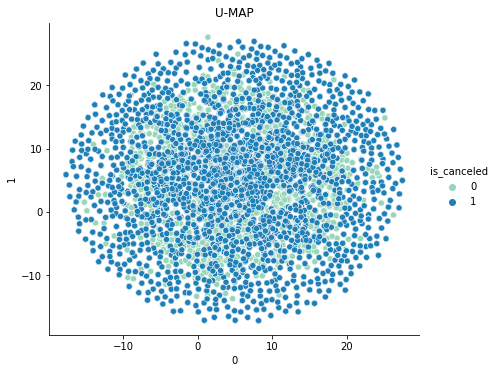

In [17]:
# UMAP for visualization with 2d ( could be 3d if needed )
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0).fit_transform(X_train_resampled_std)
proj_2d = pd.DataFrame(data = umap_2d)
proj_2d = pd.concat([proj_2d.reset_index().drop(['index'],axis=1),y_train_resampled.reset_index().drop(['index'],axis=1)], axis=1)

sns.pairplot(x_vars=0, y_vars=1, data=proj_2d, hue="is_canceled",palette="YlGnBu",size=5,aspect=1.2)
plt.title('U-MAP')
plt.show()

In [ ]:
# Import required libraries
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply PCA on the training set
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)

# Train a logistic regression model on the preprocessed training set
model = LogisticRegression()
model.fit(X_train_pca, y_train)

# Apply the same PCA transformation to the test set
X_test_pca = pca.transform(X_test)

# Use the trained model to make predictions on the test set
y_pred = model.predict(X_test_pca)



### Testing if the google drive uploads are readable

##### Auto Encoder

In [54]:
url = 'https://drive.google.com/file/d/1E9bFoMAwMVPMkZHmMQfWvSgaWoCLtKp4/view?usp=share_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df_y_test = pd.read_pickle(url)
df_y_test.head()

17143     0
288071    0
403516    0
382751    0
36415     0
Name: isFraud, dtype: int8

In [55]:
url = 'https://drive.google.com/file/d/1dknbQLJhQsbSFDNIpwjxZQwPc3fF14yF/view?usp=share_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df_y_train = pd.read_pickle(url)
df_y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int8

In [56]:
url = 'https://drive.google.com/file/d/105vmXogIQU8srmtdzfCHYQ9G-T7Iu5hl/view?usp=share_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df_X_test = pd.read_pickle(url)
df_X_test.head()

,0,1,2,3,4,5,6,7,8,9
0,7.753103,0.000000,12.101476,0.0,2.849138,7.366708,0.0,0.000000,13.792309,1.935020
1,3.605611,0.149467,9.363172,0.0,1.098339,12.561184,0.0,7.492346,8.324308,8.584323
2,3.699365,0.000000,6.206605,0.0,3.048371,3.739421,0.0,0.000000,12.409950,8.039093
3,4.997734,1.900816,8.737974,0.0,5.913760,0.000000,0.0,0.000000,5.463495,8.636847
4,4.055901,0.000000,12.177122,0.0,1.169135,13.404551,0.0,3.746340,7.998685,4.520480


In [57]:
url = 'https://drive.google.com/file/d/1QemU274E0c14R8uknuipP20rNgDSLzcg/view?usp=share_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df_X_train = pd.read_pickle(url)
df_X_train.head()

,0,1,2,3,4,5,6,7,8,9
0,7.753103,0.000000,12.101476,0.0,2.849138,7.366708,0.0,0.000000,13.792309,1.935020
1,3.605611,0.149467,9.363172,0.0,1.098339,12.561184,0.0,7.492346,8.324308,8.584323
2,3.699365,0.000000,6.206605,0.0,3.048371,3.739421,0.0,0.000000,12.409950,8.039093
3,4.997734,1.900816,8.737974,0.0,5.913760,0.000000,0.0,0.000000,5.463495,8.636847
4,4.055901,0.000000,12.177122,0.0,1.169135,13.404551,0.0,3.746340,7.998685,4.520480


#### PCA

In [58]:
url = 'https://drive.google.com/file/d/1j_TvH1bVTIkDunKPigUEMScnPbWCBObD/view?usp=share_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df_y_test = pd.read_pickle(url)
df_y_test.head()

17143     0
288071    0
403516    0
382751    0
36415     0
Name: isFraud, dtype: int8

In [59]:
url = 'https://drive.google.com/file/d/1_zEVE2BBYWHiIJ3kK39V_zm6duEG5Td6/view?usp=share_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df_y_train = pd.read_pickle(url)
df_y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int8

In [60]:
url = 'https://drive.google.com/file/d/1hpj2k1PV6ia6W0eLBvh53QLvlvg5owUJ/view?usp=share_link'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
df_X_test = pd.read_parquet(url)
df_X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-2263.805582,20719.861272,-60315.233714,61644.683060,3116.030427,-25369.688205,-38139.905187,-702.517208,1819.957650,45475.338417,...,88294.148554,407646.373785,-237776.036485,251876.048480,-110012.047119,-254357.948281,126975.636937,-90799.056299,36992.959101,223425.208494
1,-9422.727324,20292.511709,-78160.840088,82550.519787,9947.610388,-41243.004810,-73318.280887,46489.388469,-72288.826124,43799.850606,...,95281.413919,423910.084836,-245377.431734,265797.970579,-111711.335490,-259922.101123,133720.194168,-88985.743284,37230.353763,229712.885328
2,-9999.751769,21613.000749,-83545.348947,88235.770289,10368.572243,-44102.191584,-78256.907781,49793.739484,-77303.251469,46821.980077,...,101360.804417,452941.132706,-266092.450618,284121.667087,-119314.451246,-277112.442672,141375.042222,-97735.032906,40151.520273,245444.728982
3,-9922.198976,21493.251067,-82560.261911,87120.304342,10350.677466,-43566.987798,-77359.259117,49149.346449,-76338.965552,46255.141424,...,100648.409228,447600.430326,-259328.661038,280641.019204,-117909.823113,-274456.801857,141191.430296,-93979.600846,39298.229276,242618.266555
4,-3003.782193,17883.093746,-77812.618967,78880.179040,8510.506715,-36580.110988,-75185.439854,49058.516472,-70012.750009,42942.885413,...,92554.420103,417605.808685,-237885.155027,259195.051719,-111175.877086,-255848.515547,131403.181283,-85851.152768,38619.495203,225645.093211


In [ ]:
url = r'' # insert your folder address for PCA_X_train.parquet here
df_X_train = pd.read_parquet(url)
df_X_train.head()